In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, recall_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os
from itertools import combinations

# Configurações de visualização
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
# ===== CARREGAMENTO INICIAL DOS DADOS =====

# Carregar o dataset principal a partir de arquivo local
df = pd.read_csv('diabetes.csv')

print("\n" + "="*60)
print("📋 DADOS CARREGADOS COM SUCESSO")
print("="*60)
print(f"Dataset original: {df.shape[0]} linhas, {df.shape[1]} colunas")
print(f"\nPrimeira visão da distribuição da variável target:")
print(df['Outcome'].value_counts())
print(f"\nPercentual de balanceamento inicial:")
balanceamento = df['Outcome'].value_counts(normalize=True) * 100
print(f"Não-Diabetes: {balanceamento[0]:.1f}%")
print(f"Diabetes: {balanceamento[1]:.1f}%")
print(f"\n⚠️  Observação: Dataset desbalanceado - {balanceamento[0]:.1f}% vs {balanceamento[1]:.1f}%")
print("🔄 Será necessário tratamento de balanceamento")


📋 DADOS CARREGADOS COM SUCESSO
Dataset original: 768 linhas, 9 colunas

Primeira visão da distribuição da variável target:
Outcome
0    500
1    268
Name: count, dtype: int64

Percentual de balanceamento inicial:
Não-Diabetes: 65.1%
Diabetes: 34.9%

⚠️  Observação: Dataset desbalanceado - 65.1% vs 34.9%
🔄 Será necessário tratamento de balanceamento


In [5]:
# ===== FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS =====

print("\n" + "="*70)
print("📊 FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS")
print("="*70)

# Separar features e target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(f"\n📋 Dimensões originais:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Classes no target: {y.unique()}")

# ETAPA 1: Separar 20% para teste (conjunto final de avaliação)
print(f"\n🔄 ETAPA 1: Separando conjunto de teste (20%)")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# ETAPA 2: Dividir os 80% restantes em treino (60% total) e validação (20% total)
print(f"🔄 ETAPA 2: Separando treino e validação dos 80% restantes")
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,  # 25% de 80% = 20% do total
    random_state=42, 
    stratify=y_temp
)

print(f"\n📈 RESULTADO DA DIVISÃO:")
print("-"*50)
print(f"{'Conjunto':<12} {'Amostras':<10} {'% Total':<10} {'% Classe 0':<12} {'% Classe 1':<12}")
print("-"*50)

# Calcular estatísticas para cada conjunto
conjuntos = [
    ('Treino', X_train, y_train),
    ('Validação', X_val, y_val),
    ('Teste', X_test, y_test)
]

for nome, X_conj, y_conj in conjuntos:
    total_amostras = len(y_conj)
    perc_total = total_amostras / len(y) * 100
    classe_0 = (y_conj == 0).sum()
    classe_1 = (y_conj == 1).sum()
    perc_classe_0 = classe_0 / total_amostras * 100
    perc_classe_1 = classe_1 / total_amostras * 100
    
    print(f"{nome:<12} {total_amostras:<10} {perc_total:<10} {perc_classe_0:<12} {perc_classe_1:<12}")

print("-"*50)

# Verificar se a estratificação foi bem-sucedida
print(f"\n✅ VERIFICAÇÃO DA ESTRATIFICAÇÃO:")
original_ratio = y.mean()
print(f"Proporção original de diabetes: {original_ratio:.3f}")

for nome, _, y_conj in conjuntos:
    ratio = y_conj.mean()
    print(f"Proporção em {nome}: {ratio:.3f} (diferença: {abs(ratio - original_ratio):.3f})")

print(f"\n🎯 OBJETIVO ALCANÇADO: Todos os conjuntos mantêm proporções similares!")

# Salvar informações da divisão
divisao_info = {
    'treino_size': len(y_train),
    'val_size': len(y_val),
    'test_size': len(y_test),
    'original_ratio': original_ratio,
    'treino_ratio': y_train.mean(),
    'val_ratio': y_val.mean(),
    'test_ratio': y_test.mean()
}

print(f"\n💾 Informações da divisão salvas para referência futura.")


📊 FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS

📋 Dimensões originais:
Features (X): (768, 8)
Target (y): (768,)
Classes no target: [1 0]

🔄 ETAPA 1: Separando conjunto de teste (20%)
🔄 ETAPA 2: Separando treino e validação dos 80% restantes

📈 RESULTADO DA DIVISÃO:
--------------------------------------------------
Conjunto     Amostras   % Total    % Classe 0   % Classe 1  
--------------------------------------------------
Treino       460        59.895833333333336 65.21739130434783 34.78260869565217
Validação    154        20.052083333333336 64.93506493506493 35.064935064935064
Teste        154        20.052083333333336 64.93506493506493 35.064935064935064
--------------------------------------------------

✅ VERIFICAÇÃO DA ESTRATIFICAÇÃO:
Proporção original de diabetes: 0.349
Proporção em Treino: 0.348 (diferença: 0.001)
Proporção em Validação: 0.351 (diferença: 0.002)
Proporção em Teste: 0.351 (diferença: 0.002)

🎯 OBJETIVO ALCANÇADO: Todos os conjuntos mantêm proporções similares!


📊 FASE 3.2: TRATAMENTO DE OUTLIERS COM VISUALIZAÇÃO DETALHADA

📈 RESULTADO GERAL DA REMOÇÃO DE OUTLIERS:
Amostras originais: 460
Amostras após limpeza: 427
Total de outliers removidos: 33
Percentual removido: 7.2%

📊 DETALHES POR FEATURE:
--------------------------------------------------------------------------------------------------------------
Feature                   Q1       Q3       IQR      Lower    Upper    Outliers  %     
--------------------------------------------------------------------------------------------------------------
Pregnancies               1.00     6.00     5.00     -11.50   18.50    0         0.0   
Glucose                   99.00    140.00   41.00    -3.50    242.50   0         0.0   
BloodPressure             62.00    80.00    18.00    17.00    125.00   18        3.9   
SkinThickness             0.00     33.00    33.00    -82.50   115.50   0         0.0   
Insulin                   0.00     130.00   130.00   -325.00  455.00   8         1.8   
BMI       

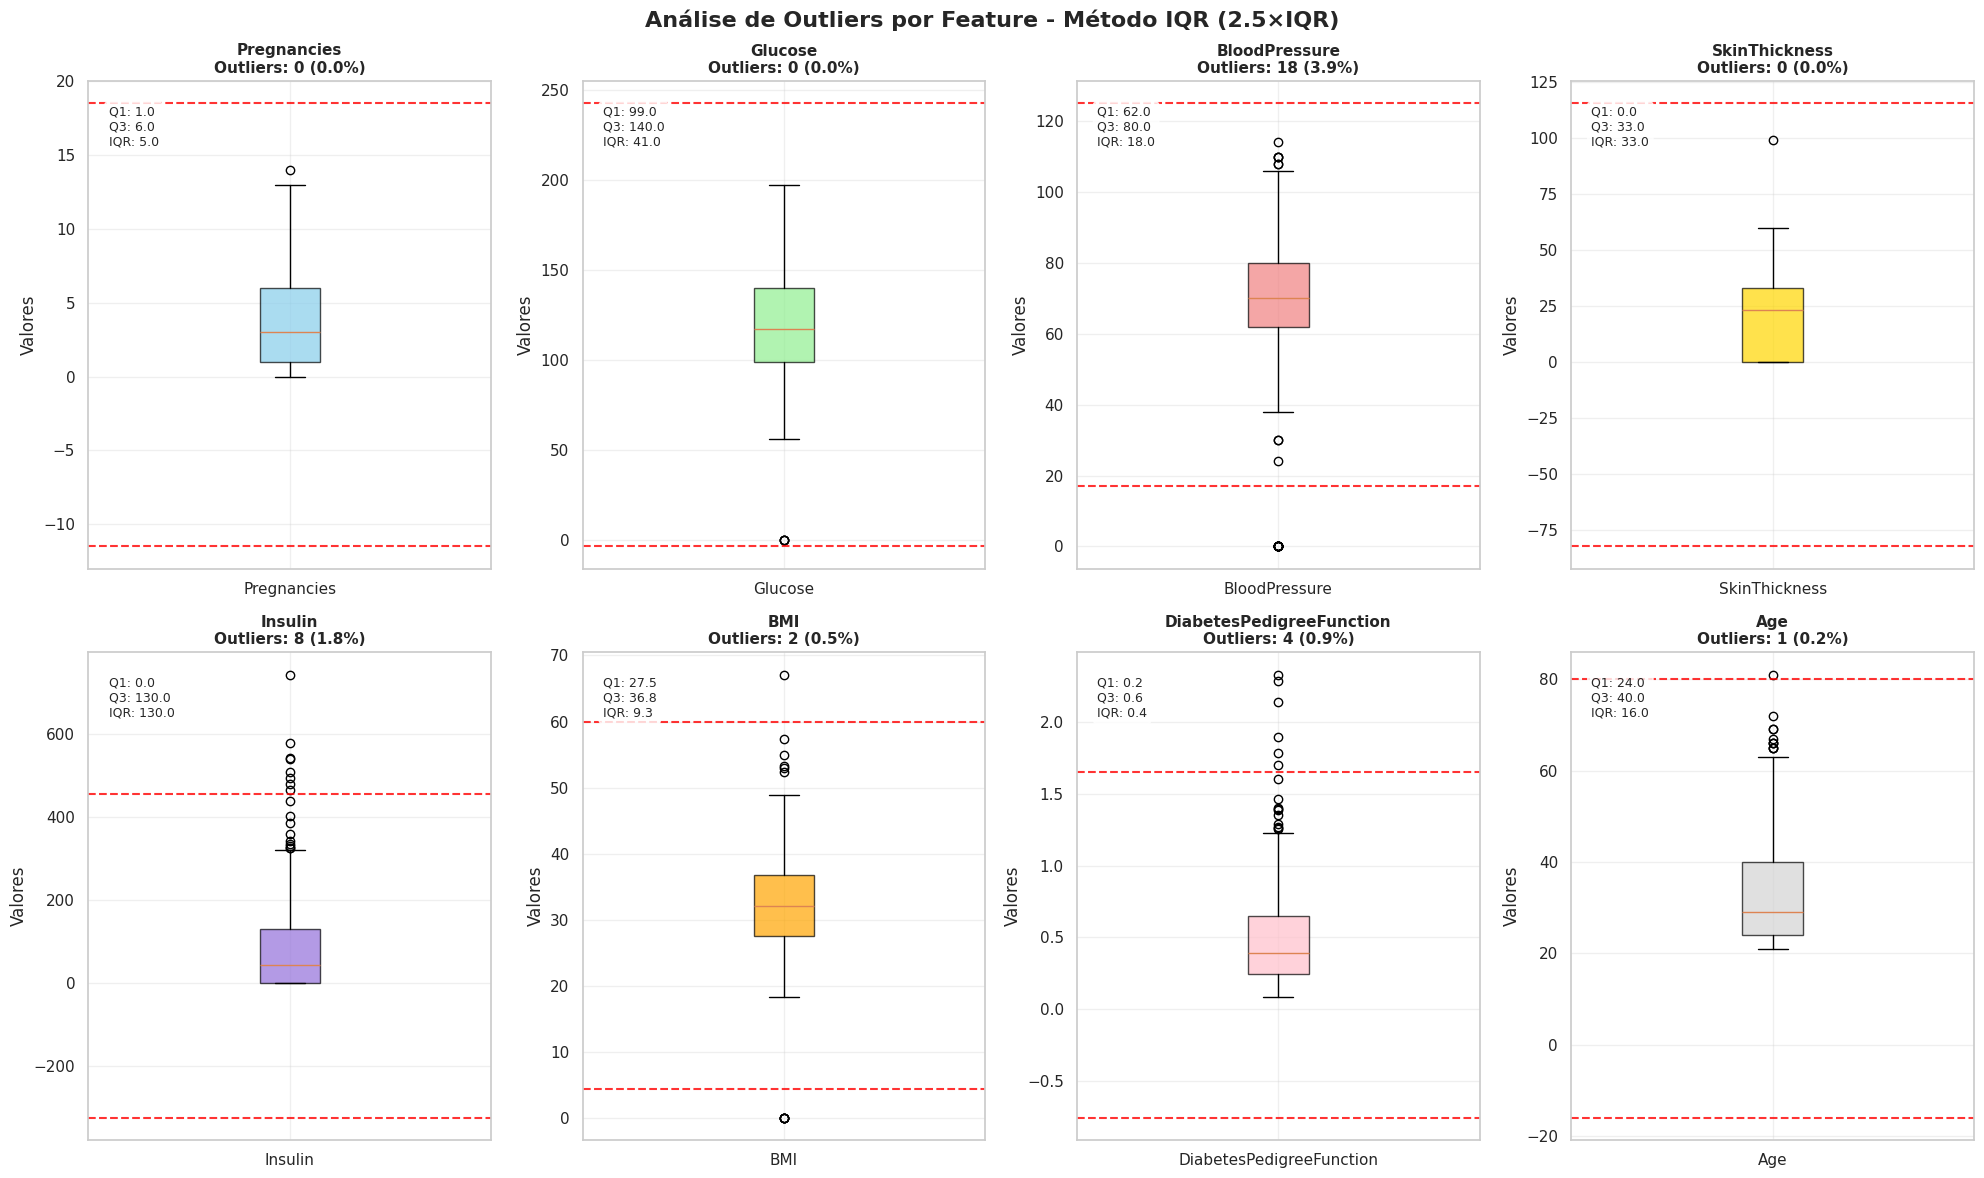

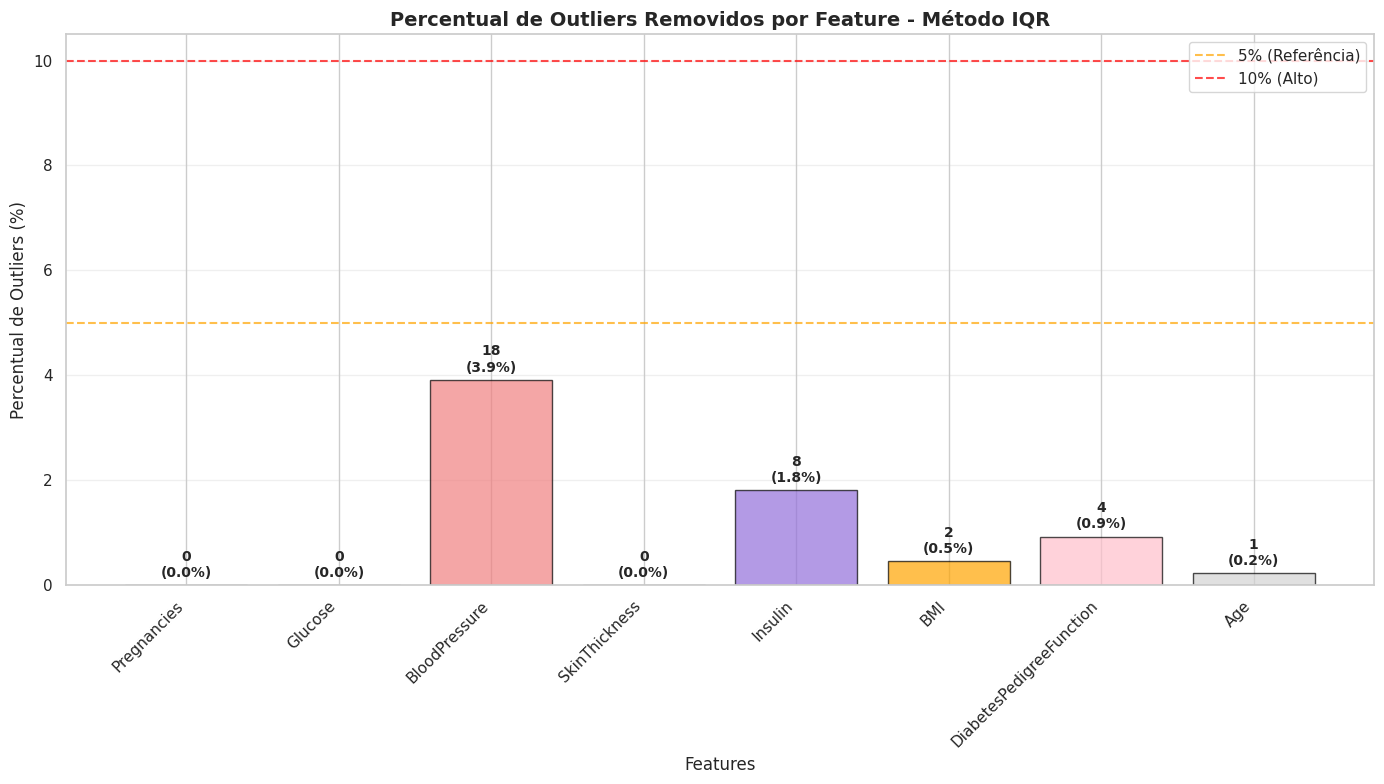

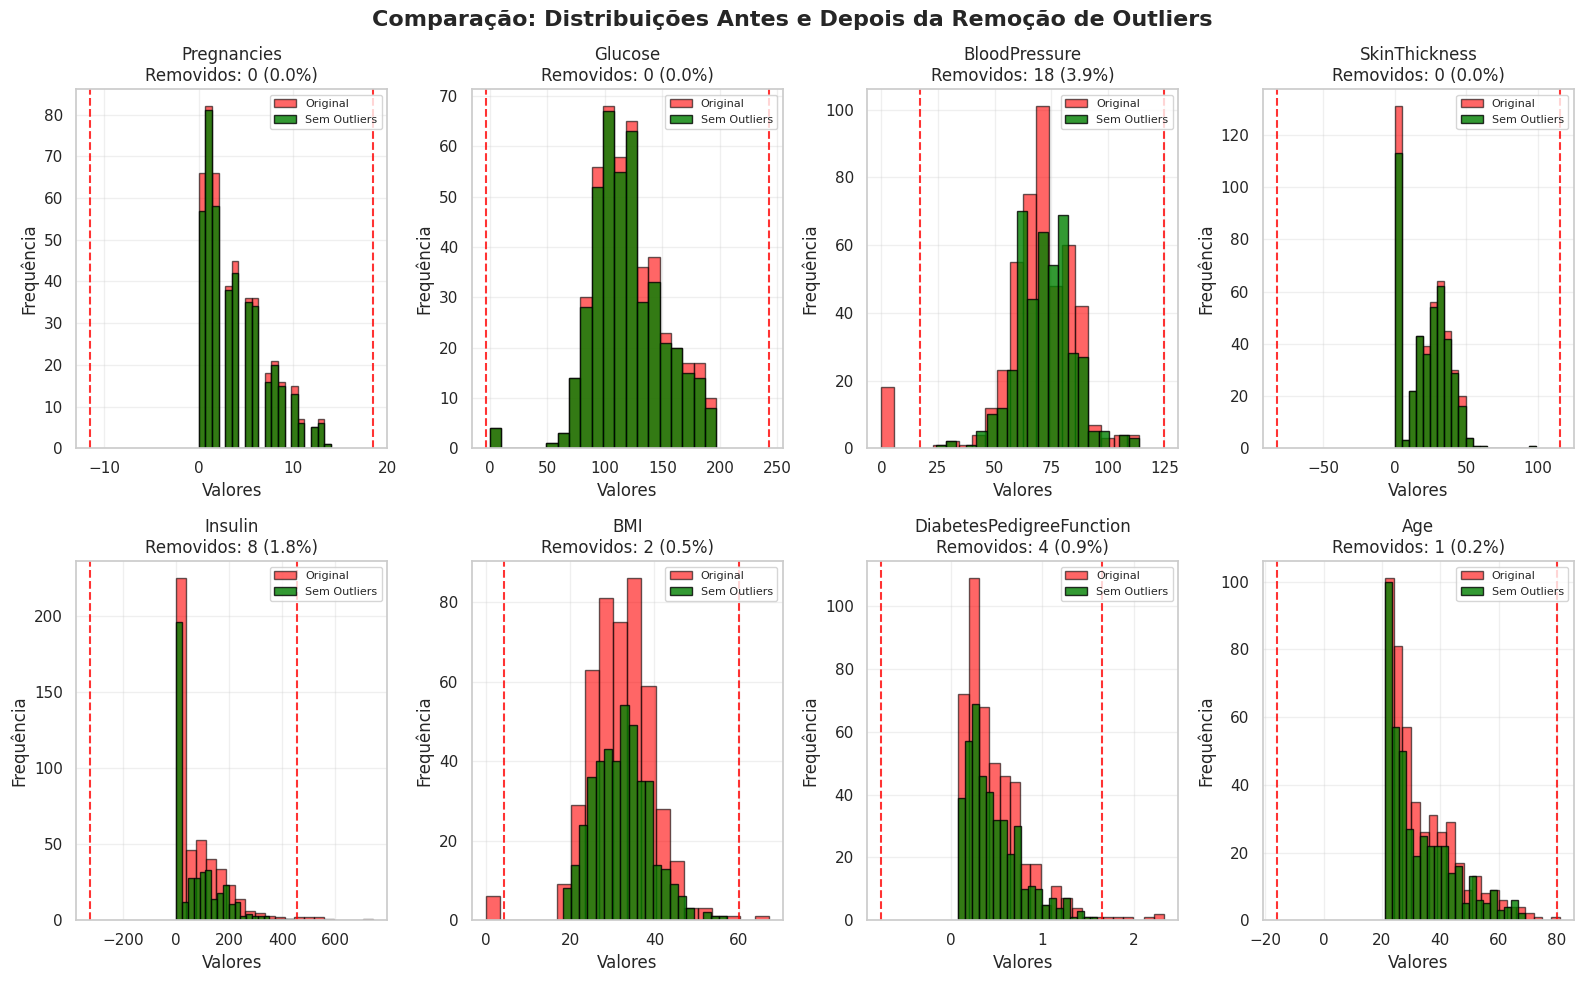


📋 IMPACTO DETALHADO DA REMOÇÃO DE OUTLIERS:
Feature                   Min Orig  Max Orig  Min Limpo  Max Limpo  Abaixo  Acima  Total 
Pregnancies               0.0       14.0      0.0        14.0       0       0      0     
Glucose                   0.0       197.0     0.0        197.0      0       0      0     
BloodPressure             0.0       114.0     24.0       114.0      18      0      18    
SkinThickness             0.0       99.0      0.0        99.0       0       0      0     
Insulin                   0.0       744.0     0.0        440.0      0       8      8     
BMI                       0.0       67.1      18.2       57.3       1       1      2     
DiabetesPedigreeFunction  0.1       2.3       0.1        1.6        0       4      4     
Age                       21.0      81.0      21.0       69.0       0       1      1     

🎯 IMPACTO NO BALANCEAMENTO DE CLASSES:
Antes da limpeza:
  Classe 0: 300 (65.2%)
  Classe 1: 160 (34.8%)
Após a limpeza:
  Classe 0: 285 (66.7%)

In [6]:
# ===== FASE 3.2: TRATAMENTO DE OUTLIERS COM VISUALIZAÇÃO =====

print("\n" + "="*70)
print("📊 FASE 3.2: TRATAMENTO DE OUTLIERS COM VISUALIZAÇÃO DETALHADA")
print("="*70)

# Função para remover outliers com informações detalhadas
def remove_outliers_iqr_detailed(data, columns):
      """
      Remove outliers usando o método IQR com informações detalhadas por feature
      """
      clean_data = data.copy()
      outlier_info = {}
      
      for column in columns:
            Q1 = clean_data[column].quantile(0.25)
            Q3 = clean_data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 2.5 * IQR
            upper_bound = Q3 + 2.5 * IQR
            
            # Identificar outliers
            outliers_mask = (clean_data[column] < lower_bound) | (clean_data[column] > upper_bound)
            outliers_count = outliers_mask.sum()
            
            # Armazenar informações
            outlier_info[column] = {
                  'Q1': Q1,
                  'Q3': Q3,
                  'IQR': IQR,
                  'lower_bound': lower_bound,
                  'upper_bound': upper_bound,
                  'outliers_count': outliers_count,
                  'outliers_percentage': (outliers_count / len(clean_data)) * 100,
                  'original_min': clean_data[column].min(),
                  'original_max': clean_data[column].max(),
                  'outliers_below': (clean_data[column] < lower_bound).sum(),
                  'outliers_above': (clean_data[column] > upper_bound).sum()
            }
            
            # Remover outliers
            clean_data = clean_data[(clean_data[column] >= lower_bound) & (clean_data[column] <= upper_bound)]
      
      return clean_data, outlier_info

# Aplicar remoção de outliers com informações detalhadas
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X_train_clean_df = pd.DataFrame(X_train, columns=feature_columns)
y_train_clean = y_train.copy()

X_train_clean_df, outlier_details = remove_outliers_iqr_detailed(X_train_clean_df, feature_columns)
y_train_clean = y_train_clean[X_train_clean_df.index]

# Calcular total de outliers removidos
total_outliers = len(X_train) - len(X_train_clean_df)

print(f"\n📈 RESULTADO GERAL DA REMOÇÃO DE OUTLIERS:")
print(f"Amostras originais: {len(X_train)}")
print(f"Amostras após limpeza: {len(X_train_clean_df)}")
print(f"Total de outliers removidos: {total_outliers}")
print(f"Percentual removido: {(total_outliers / len(X_train)) * 100:.1f}%")

# Exibir detalhes por feature
print(f"\n📊 DETALHES POR FEATURE:")
print("-" * 110)
print(f"{'Feature':<25} {'Q1':<8} {'Q3':<8} {'IQR':<8} {'Lower':<8} {'Upper':<8} {'Outliers':<9} {'%':<6}")
print("-" * 110)

for feature, info in outlier_details.items():
      print(f"{feature:<25} {info['Q1']:<8.2f} {info['Q3']:<8.2f} {info['IQR']:<8.2f} "
              f"{info['lower_bound']:<8.2f} {info['upper_bound']:<8.2f} {info['outliers_count']:<9} "
              f"{info['outliers_percentage']:<6.1f}")

# ===== VISUALIZAÇÃO DOS OUTLIERS =====

# Criar figura com subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Análise de Outliers por Feature - Método IQR (2.5×IQR)', fontsize=16, fontweight='bold')

# Cores para os gráficos
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'mediumpurple', 'orange', 'pink', 'lightgray']

for idx, (feature, info) in enumerate(outlier_details.items()):
      row = idx // 4
      col = idx % 4
      
      # Dados originais
      original_data = pd.DataFrame(X_train, columns=feature_columns)[feature]
      
      # Criar boxplot
      box_data = [original_data]
      bp = axes[row, col].boxplot(box_data, patch_artist=True, tick_labels=[feature])
      bp['boxes'][0].set_facecolor(colors[idx])
      bp['boxes'][0].set_alpha(0.7)
      
      # Adicionar linhas de referência IQR
      axes[row, col].axhline(y=info['lower_bound'], color='red', linestyle='--', 
                                      alpha=0.8, label=f'Lower: {info["lower_bound"]:.1f}')
      axes[row, col].axhline(y=info['upper_bound'], color='red', linestyle='--', 
                                      alpha=0.8, label=f'Upper: {info["upper_bound"]:.1f}')
      
      # Configurar título e labels
      axes[row, col].set_title(f'{feature}\nOutliers: {info["outliers_count"]} ({info["outliers_percentage"]:.1f}%)', 
                                          fontsize=11, fontweight='bold')
      axes[row, col].set_ylabel('Valores')
      axes[row, col].grid(True, alpha=0.3)
      
      # Adicionar texto com estatísticas
      stats_text = f"Q1: {info['Q1']:.1f}\nQ3: {info['Q3']:.1f}\nIQR: {info['IQR']:.1f}"
      axes[row, col].text(0.05, 0.95, stats_text, transform=axes[row, col].transAxes, 
                                 verticalalignment='top', fontsize=9, 
                                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# ===== GRÁFICO DE BARRAS COM PERCENTUAL DE OUTLIERS =====

plt.figure(figsize=(14, 8))

features = list(outlier_details.keys())
outlier_percentages = [outlier_details[feature]['outliers_percentage'] for feature in features]
outlier_counts = [outlier_details[feature]['outliers_count'] for feature in features]

# Criar gráfico de barras
bars = plt.bar(features, outlier_percentages, color=colors, alpha=0.7, edgecolor='black', linewidth=1)

# Adicionar valores nas barras
for i, (bar, count, percentage) in enumerate(zip(bars, outlier_counts, outlier_percentages)):
      plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                   f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')

plt.title('Percentual de Outliers Removidos por Feature - Método IQR', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percentual de Outliers (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar linha de referência
plt.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='5% (Referência)')
plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='10% (Alto)')

plt.legend()
plt.tight_layout()
plt.show()

# ===== COMPARAÇÃO ANTES E DEPOIS =====

plt.figure(figsize=(16, 10))

for idx, feature in enumerate(feature_columns):
      plt.subplot(2, 4, idx + 1)
      
      # Dados originais e limpos
      original_data = pd.DataFrame(X_train, columns=feature_columns)[feature]
      clean_data = X_train_clean_df[feature]
      
      # Histogramas sobrepostos
      plt.hist(original_data, bins=20, alpha=0.6, label='Original', color='red', edgecolor='black')
      plt.hist(clean_data, bins=20, alpha=0.8, label='Sem Outliers', color='green', edgecolor='black')
      
      # Adicionar estatísticas
      info = outlier_details[feature]
      plt.axvline(info['lower_bound'], color='red', linestyle='--', alpha=0.8)
      plt.axvline(info['upper_bound'], color='red', linestyle='--', alpha=0.8)
      
      plt.title(f'{feature}\nRemovidos: {info["outliers_count"]} ({info["outliers_percentage"]:.1f}%)')
      plt.xlabel('Valores')
      plt.ylabel('Frequência')
      plt.legend(fontsize=8)
      plt.grid(True, alpha=0.3)

plt.suptitle('Comparação: Distribuições Antes e Depois da Remoção de Outliers', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ===== IMPACTO NUMÉRICO DETALHADO =====

print(f"\n📋 IMPACTO DETALHADO DA REMOÇÃO DE OUTLIERS:")
print("=" * 115)
print(f"{'Feature':<25} {'Min Orig':<9} {'Max Orig':<9} {'Min Limpo':<10} {'Max Limpo':<10} {'Abaixo':<7} {'Acima':<6} {'Total':<6}")
print("=" * 115)

for feature, info in outlier_details.items():
      clean_data = X_train_clean_df[feature]
      print(f"{feature:<25} {info['original_min']:<9.1f} {info['original_max']:<9.1f} "
              f"{clean_data.min():<10.1f} {clean_data.max():<10.1f} "
              f"{info['outliers_below']:<7} {info['outliers_above']:<6} {info['outliers_count']:<6}")

print("=" * 115)

# ===== DISTRIBUIÇÃO DE CLASSES APÓS LIMPEZA =====

print(f"\n🎯 IMPACTO NO BALANCEAMENTO DE CLASSES:")
print(f"Antes da limpeza:")
print(f"  Classe 0: {(y_train == 0).sum()} ({(y_train == 0).mean():.1%})")
print(f"  Classe 1: {(y_train == 1).sum()} ({(y_train == 1).mean():.1%})")

print(f"Após a limpeza:")
print(f"  Classe 0: {(y_train_clean == 0).sum()} ({(y_train_clean == 0).mean():.1%})")
print(f"  Classe 1: {(y_train_clean == 1).sum()} ({(y_train_clean == 1).mean():.1%})")

# Verificar se o balanceamento foi mantido
diff_original = abs((y_train == 0).mean() - (y_train_clean == 0).mean())
if diff_original < 0.02:
      print("✅ Balanceamento original preservado!")
else:
      print("⚠️ Pequena alteração no balanceamento (normal)")

print(f"\n✅ Análise de outliers concluída!")
print(f"💾 {total_outliers} outliers removidos usando método IQR (Q1-1.5×IQR, Q3+1.5×IQR)")
print(f"🎯 Dados limpos prontos para a próxima etapa (SMOTE)")


🔄 FASE 4.2: IMPLEMENTAÇÃO DE BALANCEAMENTO - SMOTE E OVERSAMPLING

📊 ESTADO INICIAL DOS DADOS LIMPOS:
Amostras totais: 427
Classe 0 (Não-Diabetes): 285 (66.7%)
Classe 1 (Diabetes): 142 (33.3%)
Razão de desbalanceamento: 2.01:1

🧬 IMPLEMENTANDO SMOTE (Synthetic Minority Oversampling Technique)
------------------------------------------------------------
✅ SMOTE aplicado com sucesso!
Amostras originais: 427
Amostras após SMOTE: 570
Amostras sintéticas criadas: 143
Classe 0: 285 (50.0%)
Classe 1: 285 (50.0%)

📈 IMPLEMENTANDO OVERSAMPLING SIMPLES (Random Oversampling)
------------------------------------------------------------
✅ Oversampling aplicado com sucesso!
Amostras originais: 427
Amostras após Oversampling: 570
Amostras duplicadas: 143
Classe 0: 285 (50.0%)
Classe 1: 285 (50.0%)

📊 CRIANDO VISUALIZAÇÃO COMPARATIVA DOS MÉTODOS


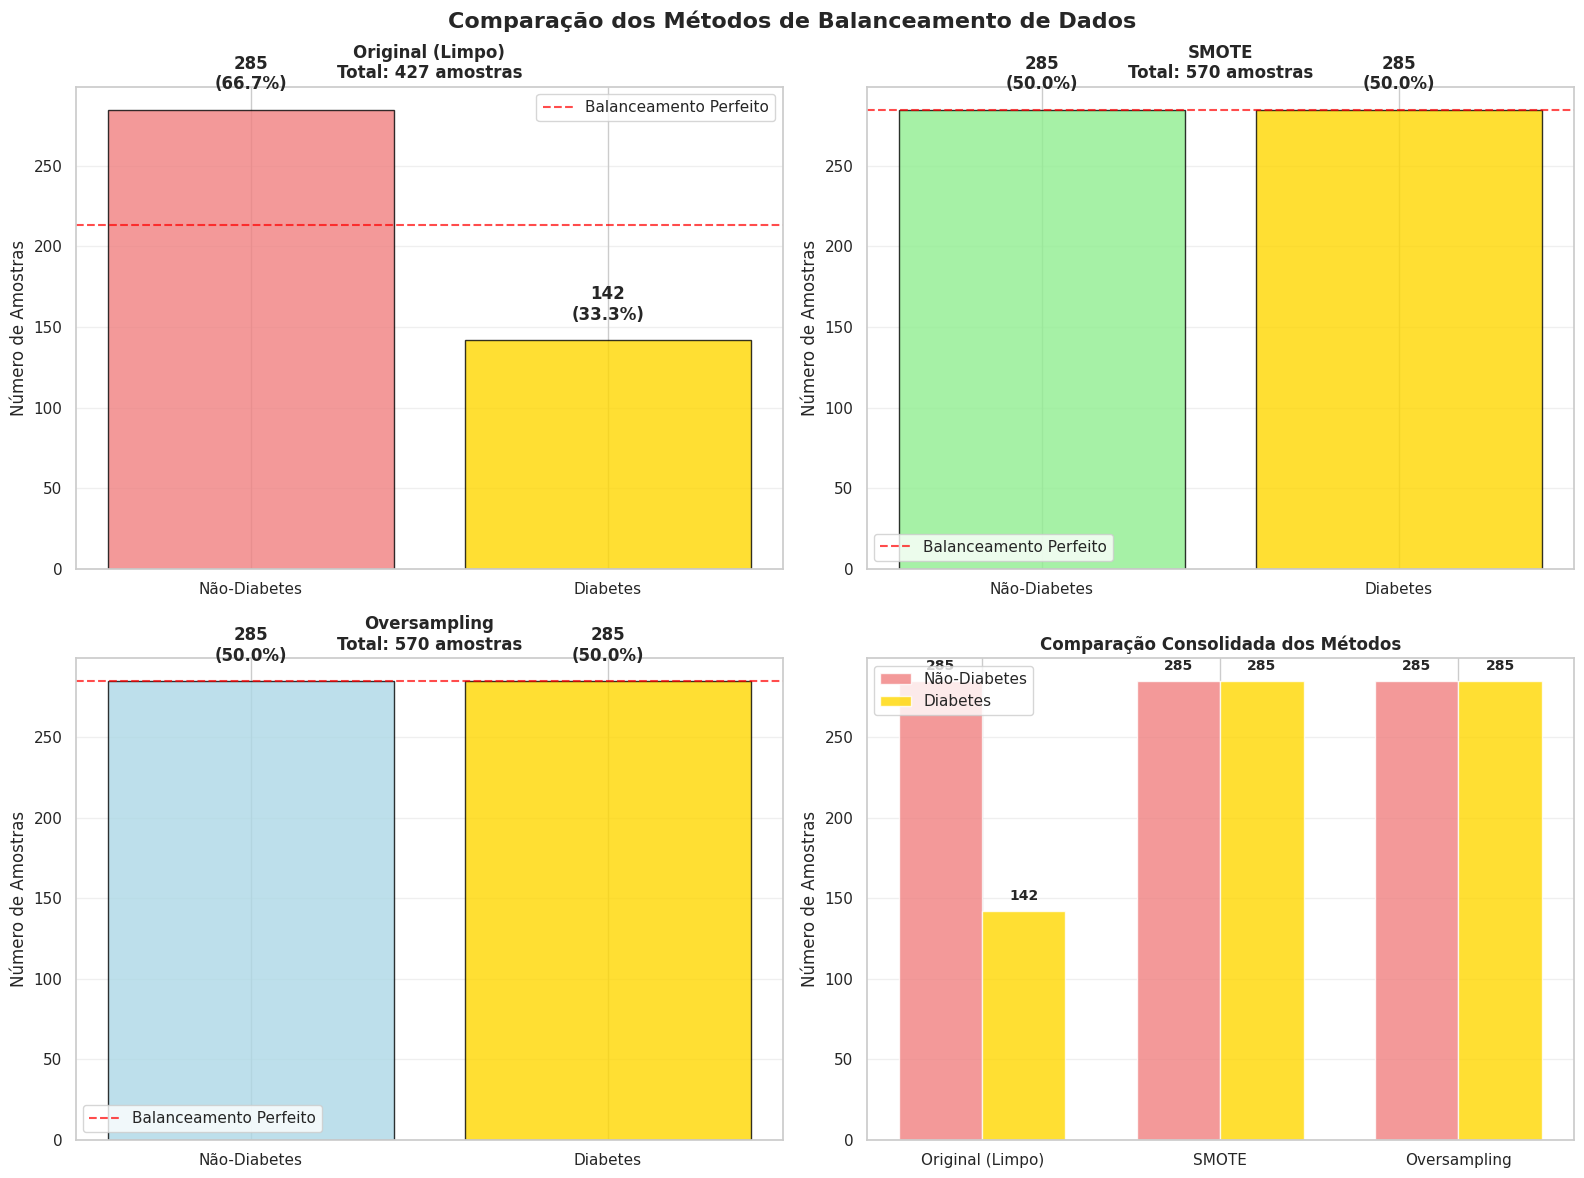


📈 RESUMO ESTATÍSTICO DOS MÉTODOS DE BALANCEAMENTO:
Método               Total    Classe 0   Classe 1   % Classe 0   % Classe 1   Razão   
Original (Limpo)     427      285        142        66.7         33.3         2.01    
SMOTE                570      285        285        50.0         50.0         1.00    
Oversampling         570      285        285        50.0         50.0         1.00    

🎯 OBJETIVO ALCANÇADO:
✅ SMOTE: Balanceamento perfeito 50.0% vs 50.0%
✅ Oversampling: Balanceamento perfeito 50.0% vs 50.0%
📊 Ambos os métodos criaram datasets balanceados para comparação
🧬 SMOTE criou 143 amostras sintéticas
📈 Oversampling duplicou 143 amostras existentes


In [36]:
# ===== FASE 4.2: IMPLEMENTAÇÃO DE BALANCEAMENTO - SMOTE E OVERSAMPLING =====

print("\n" + "="*80)
print("🔄 FASE 4.2: IMPLEMENTAÇÃO DE BALANCEAMENTO - SMOTE E OVERSAMPLING")
print("="*80)

# Converter para arrays numpy para facilitar o processamento
# Usar X_train_clean_df que foi criado anteriormente
X_train_clean_array = X_train_clean_df.values if hasattr(X_train_clean_df, 'values') else X_train_clean_df
y_train_clean_array = y_train_clean.values if hasattr(y_train_clean, 'values') else y_train_clean

print(f"\n📊 ESTADO INICIAL DOS DADOS LIMPOS:")
print(f"Amostras totais: {len(X_train_clean_array)}")
print(f"Classe 0 (Não-Diabetes): {(y_train_clean_array == 0).sum()} ({(y_train_clean_array == 0).mean():.1%})")
print(f"Classe 1 (Diabetes): {(y_train_clean_array == 1).sum()} ({(y_train_clean_array == 1).mean():.1%})")
print(f"Razão de desbalanceamento: {(y_train_clean_array == 0).sum() / (y_train_clean_array == 1).sum():.2f}:1")

# ===== IMPLEMENTAÇÃO DO SMOTE =====
print(f"\n🧬 IMPLEMENTANDO SMOTE (Synthetic Minority Oversampling Technique)")
print("-"*60)

# Configurar SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)

# Aplicar SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_clean_array, y_train_clean_array)

print(f"✅ SMOTE aplicado com sucesso!")
print(f"Amostras originais: {len(X_train_clean_array)}")
print(f"Amostras após SMOTE: {len(X_train_smote)}")
print(f"Amostras sintéticas criadas: {len(X_train_smote) - len(X_train_clean_array)}")
print(f"Classe 0: {(y_train_smote == 0).sum()} ({(y_train_smote == 0).mean():.1%})")
print(f"Classe 1: {(y_train_smote == 1).sum()} ({(y_train_smote == 1).mean():.1%})")

# ===== IMPLEMENTAÇÃO DO OVERSAMPLING SIMPLES =====
print(f"\n📈 IMPLEMENTANDO OVERSAMPLING SIMPLES (Random Oversampling)")
print("-"*60)

from imblearn.over_sampling import RandomOverSampler

# Configurar Random Oversampler
oversampler = RandomOverSampler(random_state=42)

# Aplicar Oversampling
X_train_oversample, y_train_oversample = oversampler.fit_resample(X_train_clean_array, y_train_clean_array)

print(f"✅ Oversampling aplicado com sucesso!")
print(f"Amostras originais: {len(X_train_clean_array)}")
print(f"Amostras após Oversampling: {len(X_train_oversample)}")
print(f"Amostras duplicadas: {len(X_train_oversample) - len(X_train_clean_array)}")
print(f"Classe 0: {(y_train_oversample == 0).sum()} ({(y_train_oversample == 0).mean():.1%})")
print(f"Classe 1: {(y_train_oversample == 1).sum()} ({(y_train_oversample == 1).mean():.1%})")

# ===== COMPARAÇÃO VISUAL DOS MÉTODOS DE BALANCEAMENTO =====
print(f"\n📊 CRIANDO VISUALIZAÇÃO COMPARATIVA DOS MÉTODOS")

# Criar visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparação dos Métodos de Balanceamento de Dados', fontsize=16, fontweight='bold')

# Dados para comparação
metodos = {
    'Original (Limpo)': (y_train_clean_array, 'lightcoral'),
    'SMOTE': (y_train_smote, 'lightgreen'),
    'Oversampling': (y_train_oversample, 'lightblue')
}

# Posições dos subplots
posicoes = [(0, 0), (0, 1), (1, 0)]

# Criar gráficos de distribuição
for i, (metodo, (y_data, cor)) in enumerate(metodos.items()):
    row, col = posicoes[i]
    
    # Contagem de classes
    unique, counts = np.unique(y_data, return_counts=True)
    percentages = counts / len(y_data) * 100
    
    # Gráfico de barras
    bars = axes[row, col].bar(['Não-Diabetes', 'Diabetes'], counts, 
                              color=[cor, 'gold'], alpha=0.8, edgecolor='black')
    
    # Adicionar percentuais nas barras
    for bar, count, perc in zip(bars, counts, percentages):
        axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                           f'{count}\n({perc:.1f}%)', ha='center', va='bottom', fontweight='bold')
    
    axes[row, col].set_title(f'{metodo}\nTotal: {len(y_data)} amostras', fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel('Número de Amostras')
    axes[row, col].grid(axis='y', alpha=0.3)
    
    # Adicionar linha de balanceamento perfeito
    axes[row, col].axhline(y=len(y_data)/2, color='red', linestyle='--', alpha=0.7, label='Balanceamento Perfeito')
    axes[row, col].legend()

# Gráfico comparativo consolidado
axes[1, 1].remove()
ax_consolidado = fig.add_subplot(2, 2, 4)

# Dados para gráfico consolidado - CORREÇÃO DO ERRO
metodos_nomes = list(metodos.keys())
classe_0_counts = [(y_data == 0).sum() for y_data, _ in metodos.values()]
classe_1_counts = [(y_data == 1).sum() for y_data, _ in metodos.values()]

x = np.arange(len(metodos_nomes))
width = 0.35

bars1 = ax_consolidado.bar(x - width/2, classe_0_counts, width, label='Não-Diabetes', color='lightcoral', alpha=0.8)
bars2 = ax_consolidado.bar(x + width/2, classe_1_counts, width, label='Diabetes', color='gold', alpha=0.8)

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax_consolidado.text(bar.get_x() + bar.get_width()/2., height + 5,
                           f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax_consolidado.set_title('Comparação Consolidada dos Métodos', fontsize=12, fontweight='bold')
ax_consolidado.set_ylabel('Número de Amostras')
ax_consolidado.set_xticks(x)
ax_consolidado.set_xticklabels(metodos_nomes)
ax_consolidado.legend()
ax_consolidado.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ===== RESUMO ESTATÍSTICO =====
print(f"\n📈 RESUMO ESTATÍSTICO DOS MÉTODOS DE BALANCEAMENTO:")
print("="*80)
print(f"{'Método':<20} {'Total':<8} {'Classe 0':<10} {'Classe 1':<10} {'% Classe 0':<12} {'% Classe 1':<12} {'Razão':<8}")
print("="*80)

for metodo, (y_data, _) in metodos.items():
    total = len(y_data)
    classe_0 = (y_data == 0).sum()
    classe_1 = (y_data == 1).sum()
    perc_0 = classe_0 / total * 100
    perc_1 = classe_1 / total * 100
    razao = classe_0 / classe_1 if classe_1 > 0 else 0
    
    print(f"{metodo:<20} {total:<8} {classe_0:<10} {classe_1:<10} {perc_0:<12.1f} {perc_1:<12.1f} {razao:<8.2f}")

print("="*80)

print(f"\n🎯 OBJETIVO ALCANÇADO:")
print(f"✅ SMOTE: Balanceamento perfeito {(y_train_smote == 0).mean():.1%} vs {(y_train_smote == 1).mean():.1%}")
print(f"✅ Oversampling: Balanceamento perfeito {(y_train_oversample == 0).mean():.1%} vs {(y_train_oversample == 1).mean():.1%}")
print(f"📊 Ambos os métodos criaram datasets balanceados para comparação")
print(f"🧬 SMOTE criou {len(X_train_smote) - len(X_train_clean_array)} amostras sintéticas")
print(f"📈 Oversampling duplicou {len(X_train_oversample) - len(X_train_clean_array)} amostras existentes")


🔄 NORMALIZANDO DADOS BALANCEADOS
✅ SMOTE normalizado: (570, 8)
✅ Oversampling normalizado: (570, 8)

📊 CRIANDO BOXPLOTS DA NORMALIZAÇÃO


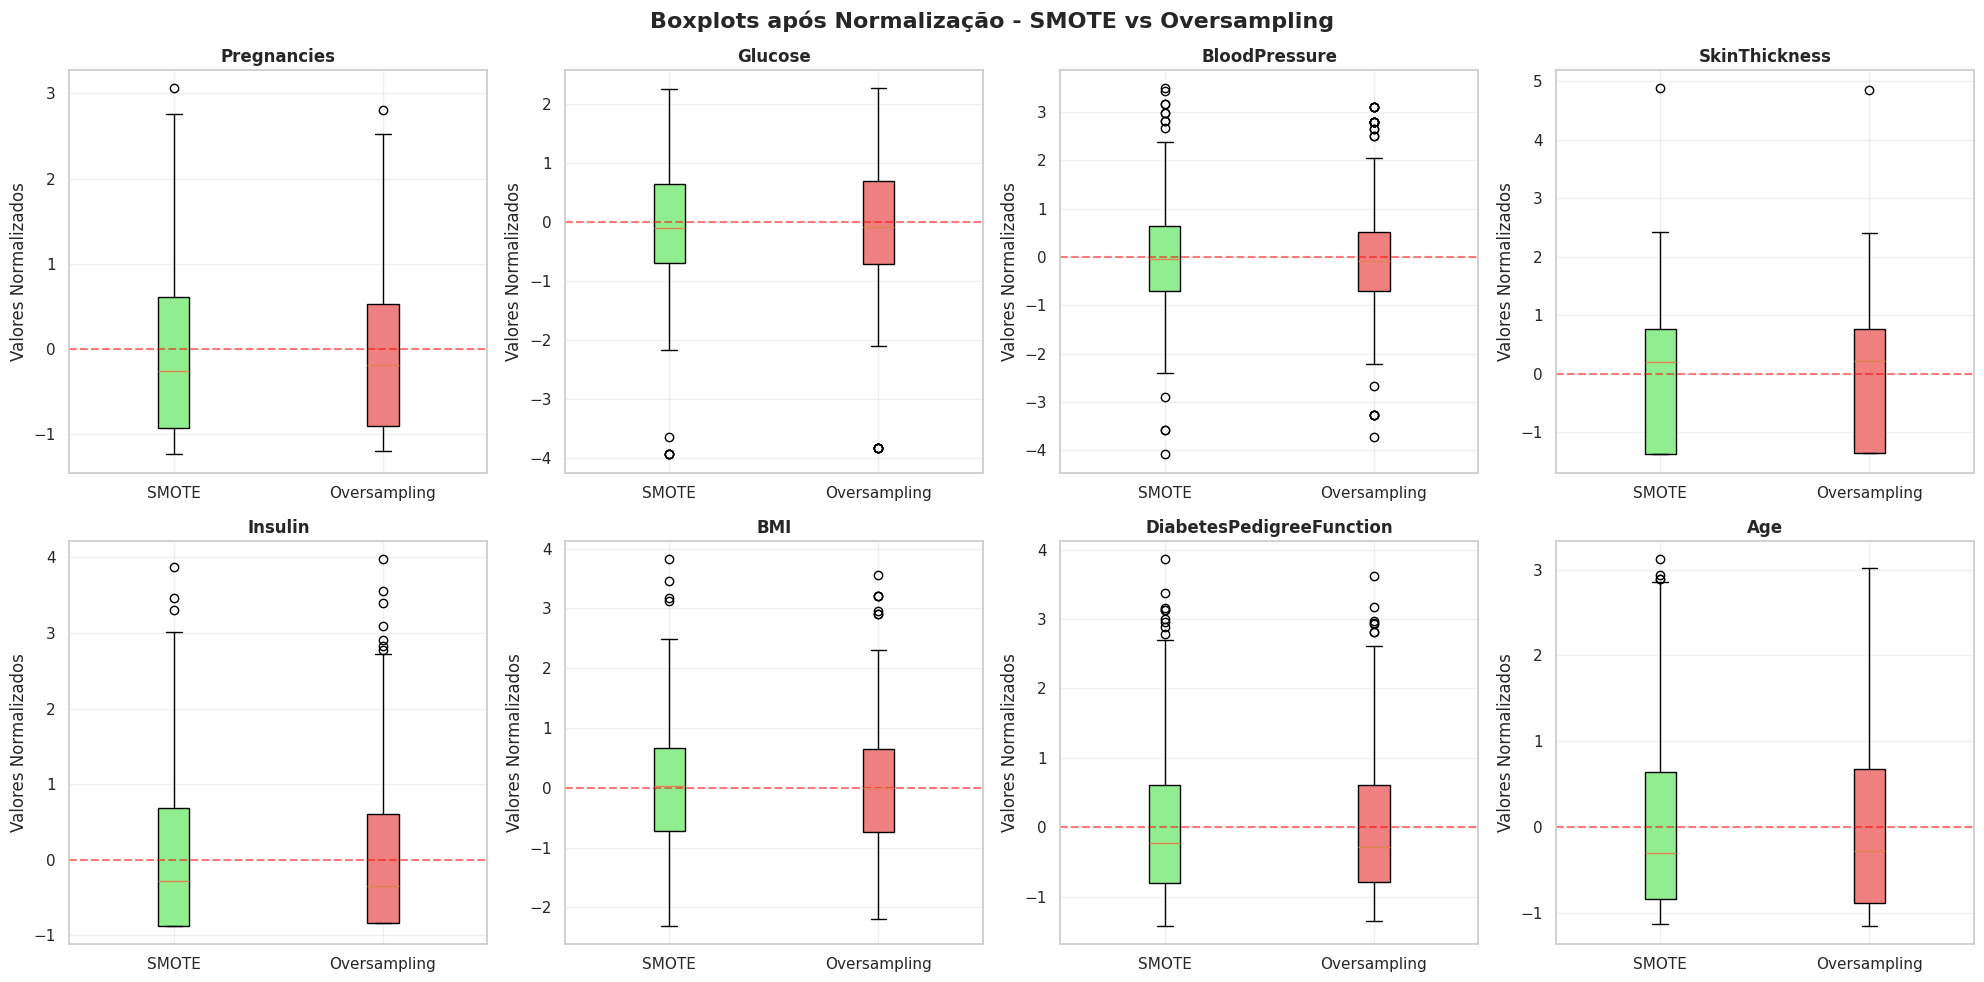


📊 BOXPLOT CONSOLIDADO TODAS AS FEATURES


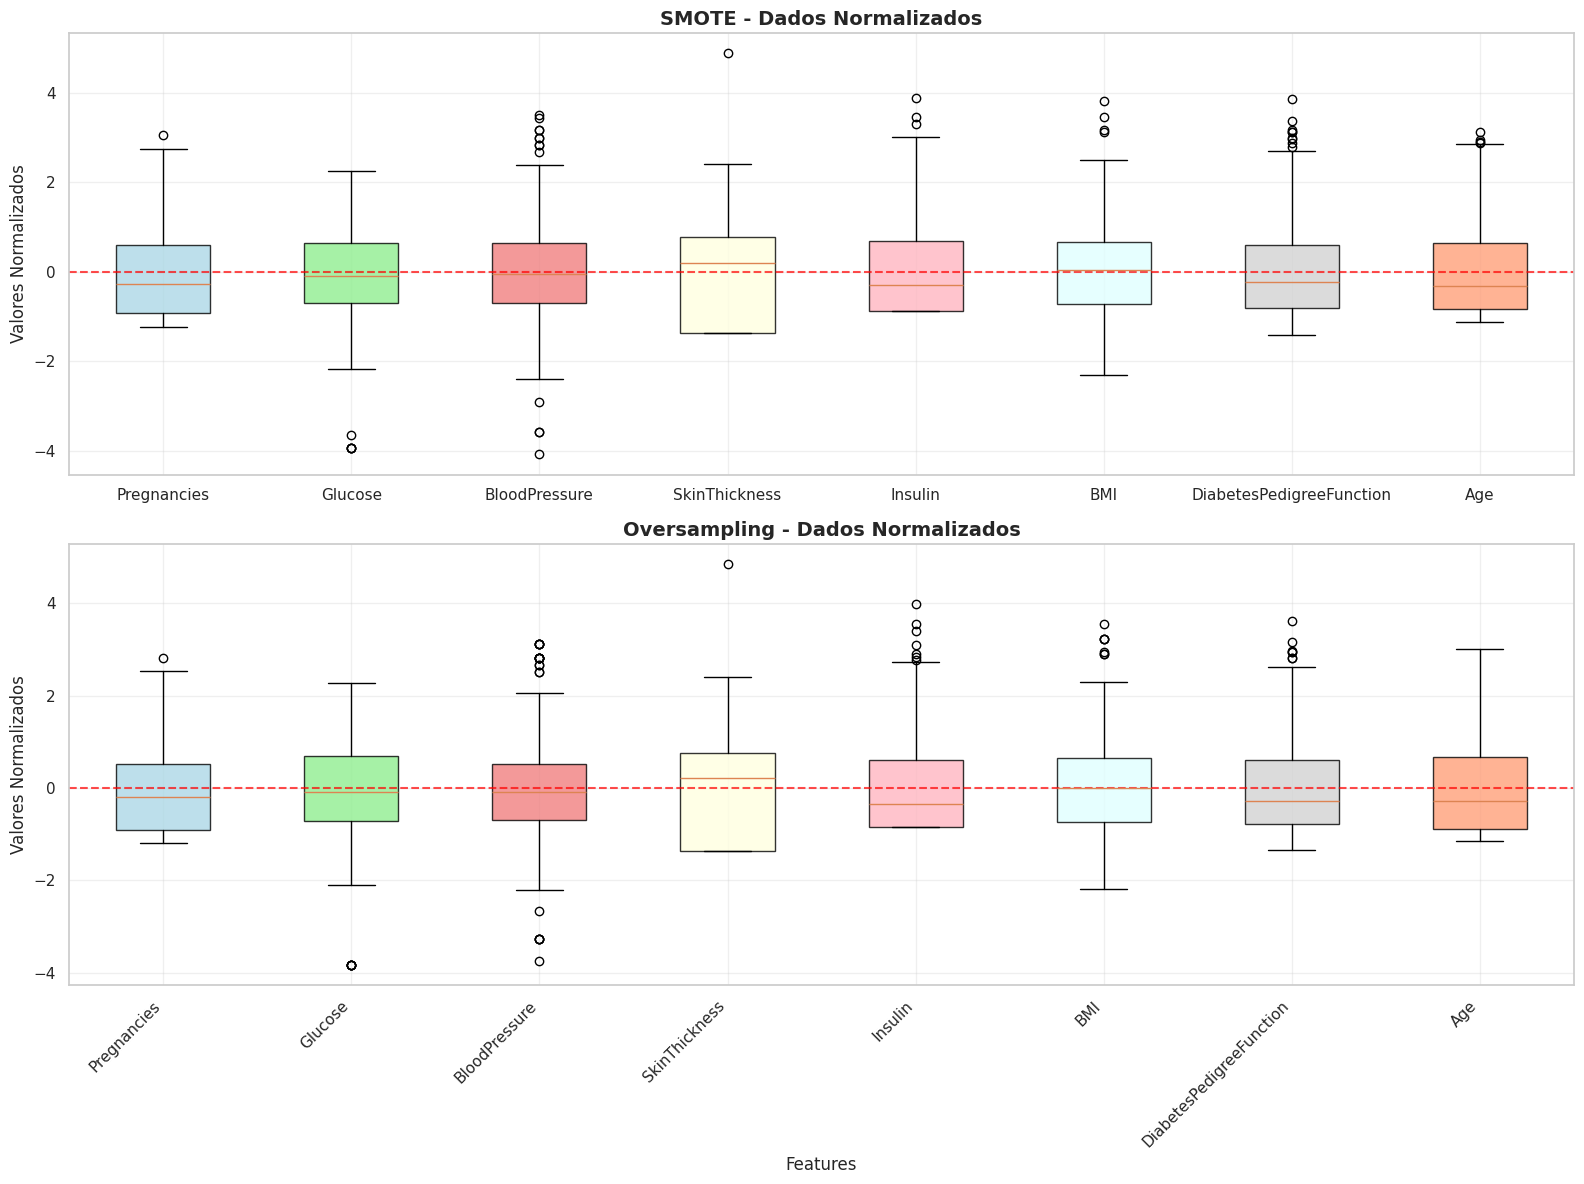


✅ NORMALIZAÇÃO E BOXPLOTS CONCLUÍDOS!
📊 Dados normalizados têm média ≈ 0 e desvio padrão ≈ 1


In [37]:
# ===== NORMALIZAÇÃO DOS DADOS BALANCEADOS =====
print(f"\n🔄 NORMALIZANDO DADOS BALANCEADOS")
print("="*60)

# Normalizar dados SMOTE
from sklearn.preprocessing import StandardScaler

scaler_smote = StandardScaler()
X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)

# Normalizar dados Oversampling
scaler_oversample = StandardScaler()
X_train_oversample_scaled = scaler_oversample.fit_transform(X_train_oversample)

print(f"✅ SMOTE normalizado: {X_train_smote_scaled.shape}")
print(f"✅ Oversampling normalizado: {X_train_oversample_scaled.shape}")

# ===== BOXPLOTS SIMPLES DA NORMALIZAÇÃO =====
print(f"\n📊 CRIANDO BOXPLOTS DA NORMALIZAÇÃO")

# Lista de features
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Criar figura
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Boxplots após Normalização - SMOTE vs Oversampling', fontsize=16, fontweight='bold')

# Boxplot para cada feature
for i, feature_name in enumerate(feature_names):
    row = i // 4
    col = i % 4
    
    # Dados normalizados
    data_smote = X_train_smote_scaled[:, i]
    data_oversample = X_train_oversample_scaled[:, i]
    
    # Criar boxplot com parâmetro corrigido
    bp = axes[row, col].boxplot([data_smote, data_oversample], 
                                tick_labels=['SMOTE', 'Oversampling'],
                                patch_artist=True)
    
    # Colorir as caixas
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    # Configurações
    axes[row, col].set_title(f'{feature_name}', fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel('Valores Normalizados')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ===== BOXPLOT CONSOLIDADO =====
print(f"\n📊 BOXPLOT CONSOLIDADO TODAS AS FEATURES")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Preparar dados para boxplot consolidado
smote_data = [X_train_smote_scaled[:, i] for i in range(len(feature_names))]
oversample_data = [X_train_oversample_scaled[:, i] for i in range(len(feature_names))]

# Boxplot SMOTE com parâmetro corrigido
bp1 = ax1.boxplot(smote_data, tick_labels=feature_names, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 
          'lightpink', 'lightcyan', 'lightgray', 'lightsalmon']

for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

ax1.set_title('SMOTE - Dados Normalizados', fontsize=14, fontweight='bold')
ax1.set_ylabel('Valores Normalizados')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Boxplot Oversampling com parâmetro corrigido
bp2 = ax2.boxplot(oversample_data, tick_labels=feature_names, patch_artist=True)

for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

ax2.set_title('Oversampling - Dados Normalizados', fontsize=14, fontweight='bold')
ax2.set_ylabel('Valores Normalizados')
ax2.set_xlabel('Features')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\n✅ NORMALIZAÇÃO E BOXPLOTS CONCLUÍDOS!")
print(f"📊 Dados normalizados têm média ≈ 0 e desvio padrão ≈ 1")

In [ ]:
# ===== DEFINIÇÃO DE PARÂMETROS DOS MODELOS =====

print("\n" + "="*70)
print("🔧 FASE 4.1: DEFINIÇÃO DE PARÂMETROS DOS MODELOS")
print("="*70)

# Definir parâmetros para cada modelo seguindo as especificações
model_params = {
    'Random Forest': {'criterion': 'gini', 'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    'Gradient Boosting': {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0, 'random_state': 42},
    'XGBoost': {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'random_state': 42},
    'Decision Tree': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42},
    'AdaBoost': {'learning_rate': 1, 'n_estimators': 100, 'random_state': 42},
    'SVM': {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'kernel': 'rbf', 'max_iter': -1, 'random_state': 42},
    'Logistic Regression': {'C': 1.0, 'max_iter': 1000, 'tol': 0.0001, 'random_state': 42},
    'kNN': {'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 5},
    'Naive Bayes': {'var_smoothing': 1e-09}
}

print(f"\n📋 PARÂMETROS CONFIGURADOS PARA {len(model_params)} MODELOS:")
print("-"*70)
print(f"{'No':<3} {'Algoritmo':<20} {'Parâmetros Principais':<45}")
print("-"*70)

# Gerar resumo dos parâmetros dinamicamente a partir de model_params
parametros_resumo = []
for i, (algoritmo, params) in enumerate(model_params.items(), 1):
    # Selecionar os principais parâmetros para exibição
    principais = []
    for k, v in params.items():
        if k in ['n_estimators', 'max_depth', 'learning_rate', 'criterion', 'C', 'kernel', 'max_iter', 'tol', 'min_samples_split', 'min_samples_leaf', 'var_smoothing']:
            principais.append(f"{k}={v}")
    resumo = ', '.join(principais)
    parametros_resumo.append((i, algoritmo, resumo))

for no, algoritmo, params in parametros_resumo:
    print(f"{no:<3} {algoritmo:<20} {params:<45}")

print("-"*70)

print(f"\n🎯 ESTRATÉGIA DE PARAMETRIZAÇÃO:")
print("• Parâmetros balanceados para comparação justa")
print("• random_state=42 para reprodutibilidade")
print("• Evita overfitting e underfitting extremos")
print("• Configuração padrão otimizada para o dataset")

print(f"\n✅ Parâmetros definidos com sucesso!")
print("🚀 Prontos para iniciar o treinamento dos modelos!")


🔧 FASE 4.1: DEFINIÇÃO DE PARÂMETROS DOS MODELOS

📋 PARÂMETROS CONFIGURADOS PARA 10 MODELOS:
----------------------------------------------------------------------
No  Algoritmo            Parâmetros Principais                        
----------------------------------------------------------------------
1   Random Forest        criterion=gini, n_estimators=100, max_depth=10
2   Gradient Boosting    criterion=friedman_mse, learning_rate=0.1, max_depth=3, n_estimators=100
3   XGBoost              learning_rate=0.3, max_depth=6, n_estimators=100
4   LightGBM             learning_rate=0.1, max_depth=-1, n_estimators=100
5   Decision Tree        criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2
6   AdaBoost             learning_rate=1, n_estimators=100            
7   SVM                  C=1.0, kernel=rbf, max_iter=-1               
8   Logistic Regression  C=1.0, max_iter=1000, tol=0.0001             
9   kNN                                                            


🏆 FASE 4.4: TREINAMENTO DOS MODELOS COM CROSS-VALIDATION E RANKING MÚLTIPLO

📊 9 MODELOS CONFIGURADOS PARA TREINAMENTO
🔄 Usando Cross-Validation com 5 folds (CV-5)
🎯 Métricas de avaliação: AUC-ROC, Recall e F1-Score

🧬 TREINAMENTO COM DADOS SMOTE:
--------------------------------------------------------------------------------
Treinando Random Forest... ✅ AUC: 0.895(±0.033) | Recall: 0.846(±0.071) | F1: 0.826(±0.040)
Treinando Gradient Boosting... ✅ AUC: 0.857(±0.048) | Recall: 0.807(±0.087) | F1: 0.783(±0.048)
Treinando XGBoost... ✅ AUC: 0.861(±0.028) | Recall: 0.811(±0.057) | F1: 0.792(±0.020)
Treinando Decision Tree... ✅ AUC: 0.723(±0.048) | Recall: 0.723(±0.088) | F1: 0.719(±0.054)
Treinando AdaBoost... ✅ AUC: 0.849(±0.043) | Recall: 0.772(±0.058) | F1: 0.774(±0.045)
Treinando SVM... ✅ AUC: 0.870(±0.031) | Recall: 0.825(±0.066) | F1: 0.802(±0.039)
Treinando Logistic Regression... ✅ AUC: 0.838(±0.035) | Recall: 0.747(±0.054) | F1: 0.750(±0.045)
Treinando kNN... ✅ AUC: 0.813(±0.037)

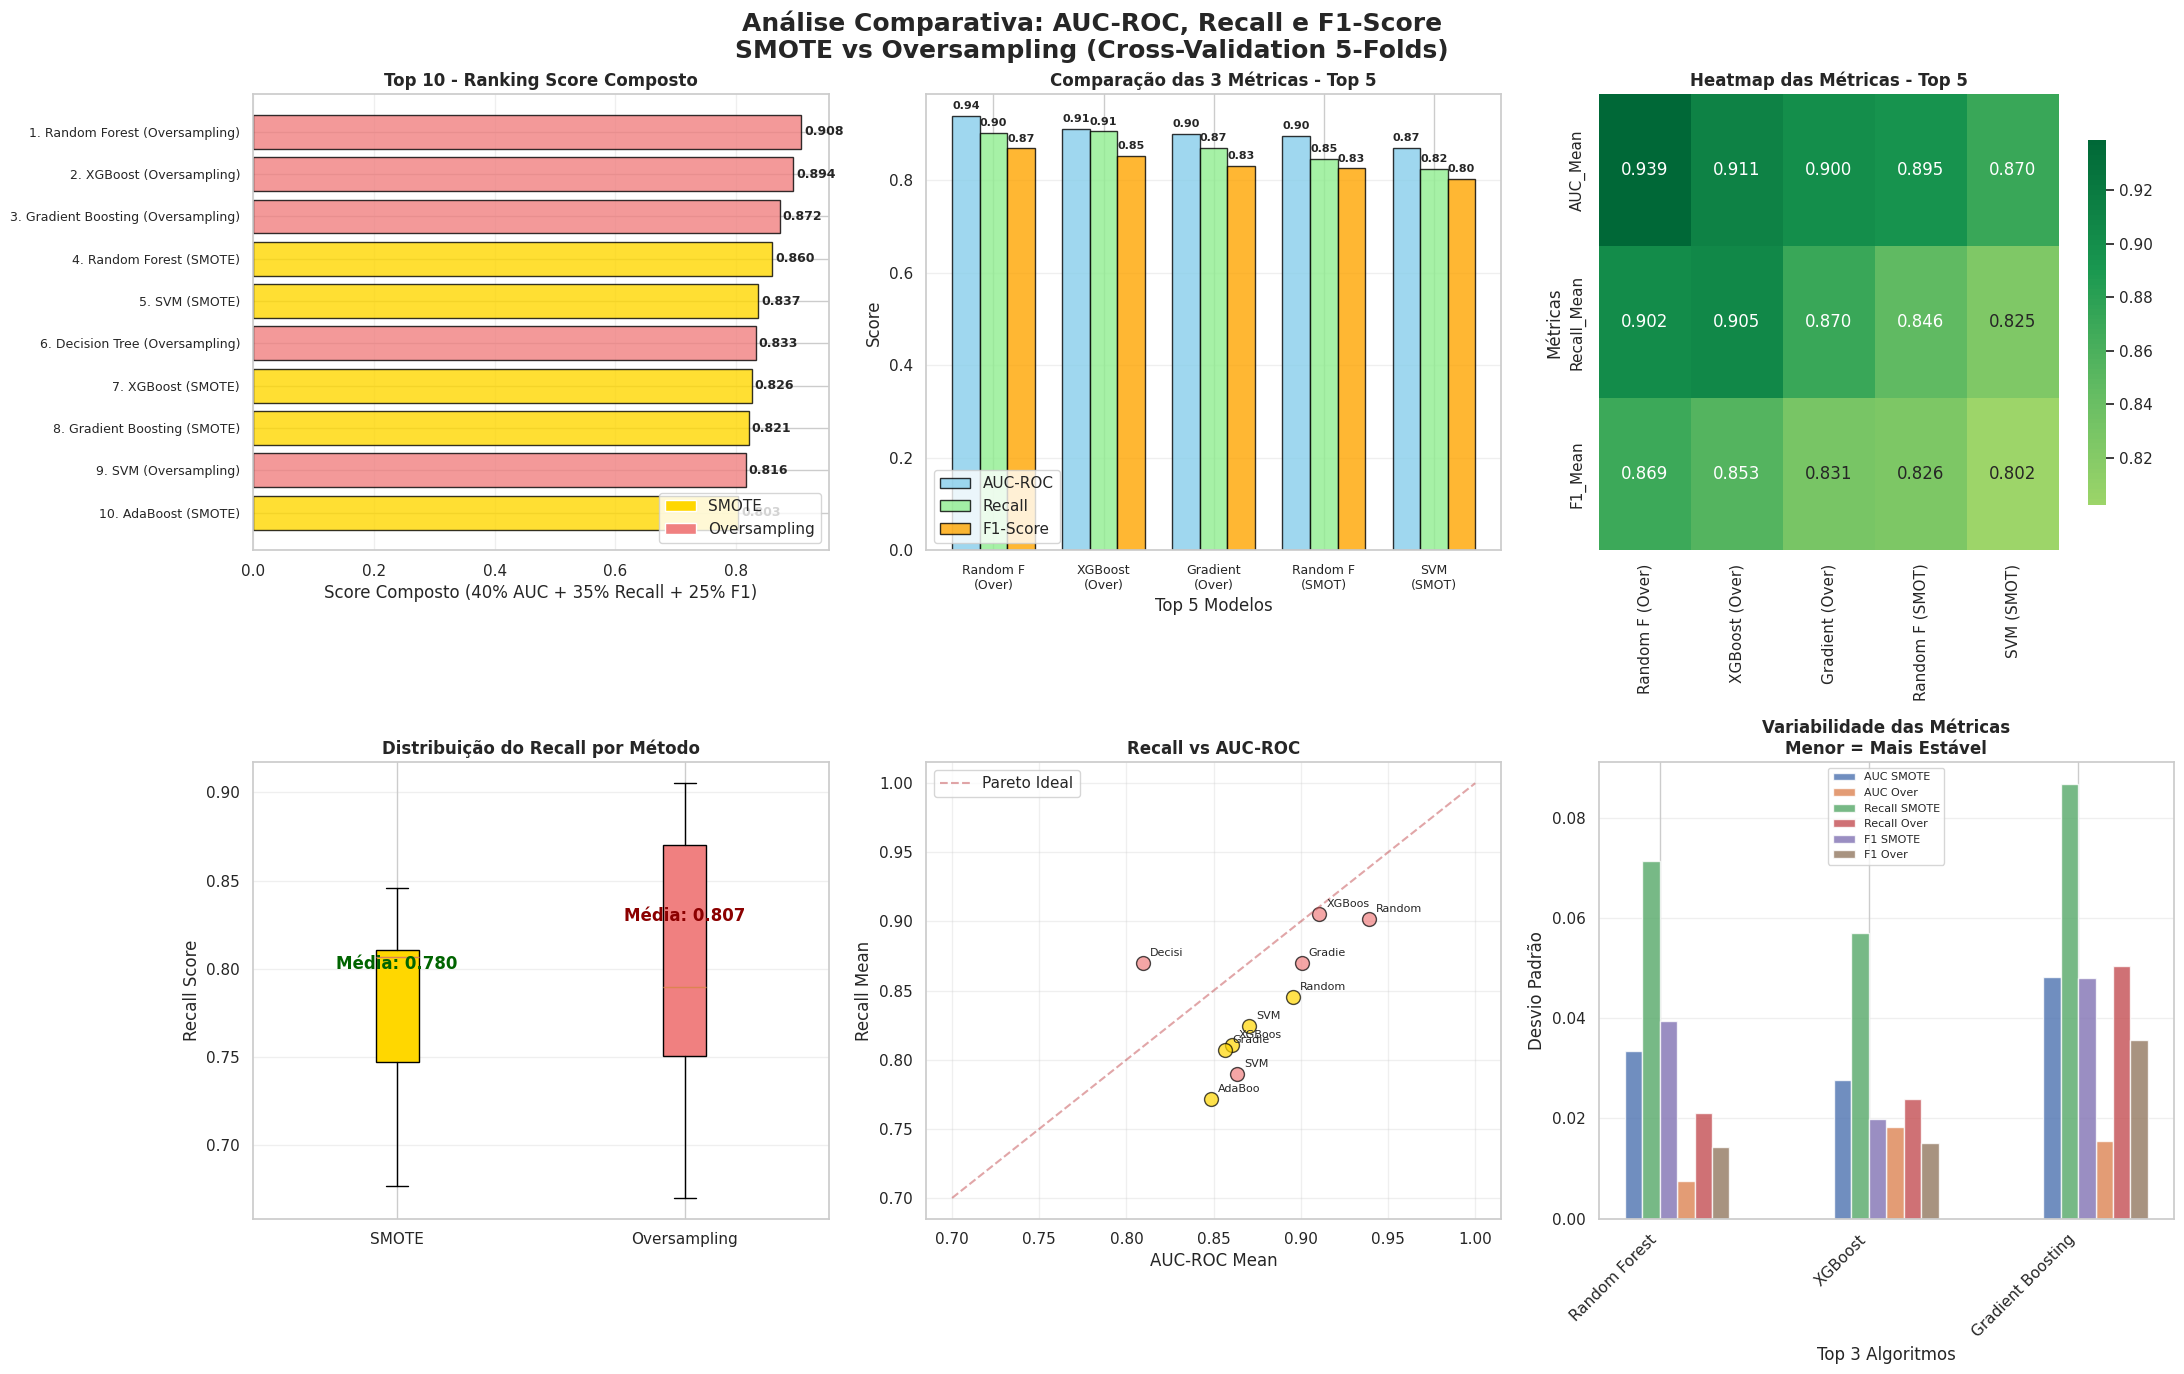


📈 RESUMO ESTATÍSTICO - MÚLTIPLAS MÉTRICAS:
Método       AUC Média  Recall Média F1 Média   AUC Desvio  Recall Desvio F1 Desvio 
SMOTE        0.835      0.780        0.769      0.0377      0.0687        0.0426    
Oversampling 0.857      0.807        0.788      0.0220      0.0489        0.0283    

🏆 RESULTADOS FINAIS - CONSIDERANDO RECALL COMO MÉTRICA CHAVE:
--------------------------------------------------------------------------------

🥇 MELHOR MODELO GERAL (Score Composto):
   Random Forest (Oversampling)
   Score: 0.908 | AUC: 0.939 | Recall: 0.902 | F1: 0.869

🎯 MELHOR MODELO POR RECALL:
   XGBoost (Oversampling)
   Recall: 0.905 | AUC: 0.911 | F1: 0.853

🧬 MELHOR SMOTE:
   Random Forest - Recall: 0.846

📈 MELHOR OVERSAMPLING:
   Random Forest - Recall: 0.902

📊 DISTRIBUIÇÃO NO TOP 10 (Score Composto):
SMOTE: 5/10 modelos (50.0%)
Oversampling: 5/10 modelos (50.0%)

🎯 ANÁLISE DO RECALL:
SMOTE - Recall médio: 0.780 (±0.069)
Oversampling - Recall médio: 0.807 (±0.049)
Diferença: SM

In [38]:
# ===== FASE 4.4: TREINAMENTO DOS MODELOS COM CV-5 E RANKING MÚLTIPLAS MÉTRICAS =====

print("\n" + "="*80)
print("🏆 FASE 4.4: TREINAMENTO DOS MODELOS COM CROSS-VALIDATION E RANKING MÚLTIPLO")
print("="*80)

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Definir modelos baseados nos parâmetros já configurados (SEM LIGHTGBM)
modelos_implementacao = {
    'Random Forest': RandomForestClassifier(**model_params['Random Forest']),
    'Gradient Boosting': GradientBoostingClassifier(**model_params['Gradient Boosting']),
    'XGBoost': XGBClassifier(**model_params['XGBoost'], eval_metric='logloss'),
    'Decision Tree': DecisionTreeClassifier(**model_params['Decision Tree']),
    'AdaBoost': AdaBoostClassifier(**model_params['AdaBoost']),
    'SVM': SVC(**model_params['SVM'], probability=True),
    'Logistic Regression': LogisticRegression(**model_params['Logistic Regression']),
    'kNN': KNeighborsClassifier(**model_params['kNN']),
    'Naive Bayes': GaussianNB(**model_params['Naive Bayes'])
}

print(f"\n📊 {len(modelos_implementacao)} MODELOS CONFIGURADOS PARA TREINAMENTO")
print(f"🔄 Usando Cross-Validation com 5 folds (CV-5)")
print(f"🎯 Métricas de avaliação: AUC-ROC, Recall e F1-Score")

# Configurar Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionários para armazenar resultados
resultados_smote = {}
resultados_oversampling = {}

# ===== TREINAMENTO COM DADOS SMOTE =====
print(f"\n🧬 TREINAMENTO COM DADOS SMOTE:")
print("-"*80)

for nome_modelo, modelo in modelos_implementacao.items():
    print(f"Treinando {nome_modelo}...", end=" ")
    
    try:
        # Cross-validation com múltiplas métricas
        auc_scores = cross_val_score(modelo, X_train_smote_scaled, y_train_smote, 
                                    cv=cv, scoring='roc_auc', n_jobs=-1)
        recall_scores = cross_val_score(modelo, X_train_smote_scaled, y_train_smote, 
                                       cv=cv, scoring='recall', n_jobs=-1)
        f1_scores = cross_val_score(modelo, X_train_smote_scaled, y_train_smote, 
                                   cv=cv, scoring='f1', n_jobs=-1)
        
        # Armazenar resultados
        resultados_smote[nome_modelo] = {
            'auc_scores': auc_scores,
            'recall_scores': recall_scores,
            'f1_scores': f1_scores,
            'mean_auc': auc_scores.mean(),
            'std_auc': auc_scores.std(),
            'mean_recall': recall_scores.mean(),
            'std_recall': recall_scores.std(),
            'mean_f1': f1_scores.mean(),
            'std_f1': f1_scores.std(),
            'min_auc': auc_scores.min(),
            'max_auc': auc_scores.max(),
            'min_recall': recall_scores.min(),
            'max_recall': recall_scores.max(),
            'min_f1': f1_scores.min(),
            'max_f1': f1_scores.max()
        }
        
        print(f"✅ AUC: {auc_scores.mean():.3f}(±{auc_scores.std():.3f}) | "
              f"Recall: {recall_scores.mean():.3f}(±{recall_scores.std():.3f}) | "
              f"F1: {f1_scores.mean():.3f}(±{f1_scores.std():.3f})")
        
    except Exception as e:
        print(f"❌ Erro: {str(e)[:50]}...")
        resultados_smote[nome_modelo] = {
            'auc_scores': np.array([0]), 'recall_scores': np.array([0]), 'f1_scores': np.array([0]),
            'mean_auc': 0, 'std_auc': 0, 'mean_recall': 0, 'std_recall': 0, 'mean_f1': 0, 'std_f1': 0,
            'min_auc': 0, 'max_auc': 0, 'min_recall': 0, 'max_recall': 0, 'min_f1': 0, 'max_f1': 0
        }

# ===== TREINAMENTO COM DADOS OVERSAMPLING =====
print(f"\n📈 TREINAMENTO COM DADOS OVERSAMPLING:")
print("-"*80)

for nome_modelo, modelo in modelos_implementacao.items():
    print(f"Treinando {nome_modelo}...", end=" ")
    
    try:
        # Cross-validation com múltiplas métricas
        auc_scores = cross_val_score(modelo, X_train_oversample_scaled, y_train_oversample, 
                                    cv=cv, scoring='roc_auc', n_jobs=-1)
        recall_scores = cross_val_score(modelo, X_train_oversample_scaled, y_train_oversample, 
                                       cv=cv, scoring='recall', n_jobs=-1)
        f1_scores = cross_val_score(modelo, X_train_oversample_scaled, y_train_oversample, 
                                   cv=cv, scoring='f1', n_jobs=-1)
        
        # Armazenar resultados
        resultados_oversampling[nome_modelo] = {
            'auc_scores': auc_scores,
            'recall_scores': recall_scores,
            'f1_scores': f1_scores,
            'mean_auc': auc_scores.mean(),
            'std_auc': auc_scores.std(),
            'mean_recall': recall_scores.mean(),
            'std_recall': recall_scores.std(),
            'mean_f1': f1_scores.mean(),
            'std_f1': f1_scores.std(),
            'min_auc': auc_scores.min(),
            'max_auc': auc_scores.max(),
            'min_recall': recall_scores.min(),
            'max_recall': recall_scores.max(),
            'min_f1': f1_scores.min(),
            'max_f1': f1_scores.max()
        }
        
        print(f"✅ AUC: {auc_scores.mean():.3f}(±{auc_scores.std():.3f}) | "
              f"Recall: {recall_scores.mean():.3f}(±{recall_scores.std():.3f}) | "
              f"F1: {f1_scores.mean():.3f}(±{f1_scores.std():.3f})")
        
    except Exception as e:
        print(f"❌ Erro: {str(e)[:50]}...")
        resultados_oversampling[nome_modelo] = {
            'auc_scores': np.array([0]), 'recall_scores': np.array([0]), 'f1_scores': np.array([0]),
            'mean_auc': 0, 'std_auc': 0, 'mean_recall': 0, 'std_recall': 0, 'mean_f1': 0, 'std_f1': 0,
            'min_auc': 0, 'max_auc': 0, 'min_recall': 0, 'max_recall': 0, 'min_f1': 0, 'max_f1': 0
        }

# ===== CRIAR RANKING CONSIDERANDO MÚLTIPLAS MÉTRICAS =====
print(f"\n🏆 CRIANDO RANKING CONSIDERANDO AUC-ROC, RECALL E F1-SCORE")

# Combinar todos os resultados
todos_resultados = []

# Adicionar resultados SMOTE
for nome_modelo, resultado in resultados_smote.items():
    # Score composto: 40% AUC + 35% Recall + 25% F1 (priorizando Recall)
    score_composto = (0.4 * resultado['mean_auc'] + 
                     0.35 * resultado['mean_recall'] + 
                     0.25 * resultado['mean_f1'])
    
    todos_resultados.append({
        'Modelo': f"{nome_modelo} (SMOTE)",
        'Método': 'SMOTE',
        'Algoritmo': nome_modelo,
        'AUC_Mean': resultado['mean_auc'],
        'AUC_Std': resultado['std_auc'],
        'Recall_Mean': resultado['mean_recall'],
        'Recall_Std': resultado['std_recall'],
        'F1_Mean': resultado['mean_f1'],
        'F1_Std': resultado['std_f1'],
        'Score_Composto': score_composto
    })

# Adicionar resultados Oversampling
for nome_modelo, resultado in resultados_oversampling.items():
    # Score composto: 40% AUC + 35% Recall + 25% F1 (priorizando Recall)
    score_composto = (0.4 * resultado['mean_auc'] + 
                     0.35 * resultado['mean_recall'] + 
                     0.25 * resultado['mean_f1'])
    
    todos_resultados.append({
        'Modelo': f"{nome_modelo} (Oversampling)",
        'Método': 'Oversampling',
        'Algoritmo': nome_modelo,
        'AUC_Mean': resultado['mean_auc'],
        'AUC_Std': resultado['std_auc'],
        'Recall_Mean': resultado['mean_recall'],
        'Recall_Std': resultado['std_recall'],
        'F1_Mean': resultado['mean_f1'],
        'F1_Std': resultado['std_f1'],
        'Score_Composto': score_composto
    })

# Converter para DataFrame e ordenar por Score Composto
df_ranking = pd.DataFrame(todos_resultados)
df_ranking = df_ranking.sort_values('Score_Composto', ascending=False).head(10)
df_ranking['Ranking'] = range(1, len(df_ranking) + 1)

# ===== EXIBIR RANKING DETALHADO =====
print(f"\n📈 TOP 10 MODELOS - RANKING POR SCORE COMPOSTO (40% AUC + 35% Recall + 25% F1):")
print("="*140)
print(f"{'Rank':<4} {'Modelo':<30} {'Método':<12} {'AUC':<8} {'Recall':<8} {'F1':<8} {'Score':<8} {'AUC±':<8} {'Recall±':<9} {'F1±':<8}")
print("="*140)

for _, row in df_ranking.iterrows():
    print(f"{row['Ranking']:<4} {row['Modelo']:<30} {row['Método']:<12} "
          f"{row['AUC_Mean']:<8.3f} {row['Recall_Mean']:<8.3f} {row['F1_Mean']:<8.3f} "
          f"{row['Score_Composto']:<8.3f} {row['AUC_Std']:<8.3f} {row['Recall_Std']:<9.3f} {row['F1_Std']:<8.3f}")

print("="*140)

# ===== RANKING SEPARADO POR CADA MÉTRICA =====
print(f"\n📊 RANKINGS INDIVIDUAIS POR MÉTRICA:")

# Ranking por AUC
print(f"\n🥇 TOP 5 POR AUC-ROC:")
print("-"*60)
df_ranking_auc = df_ranking.sort_values('AUC_Mean', ascending=False).head(5)
for i, (_, row) in enumerate(df_ranking_auc.iterrows(), 1):
    print(f"{i}. {row['Algoritmo']} ({row['Método']}) - AUC: {row['AUC_Mean']:.4f}")

# Ranking por Recall
print(f"\n🎯 TOP 5 POR RECALL:")
print("-"*60)
df_ranking_recall = df_ranking.sort_values('Recall_Mean', ascending=False).head(5)
for i, (_, row) in enumerate(df_ranking_recall.iterrows(), 1):
    print(f"{i}. {row['Algoritmo']} ({row['Método']}) - Recall: {row['Recall_Mean']:.4f}")

# Ranking por F1-Score
print(f"\n⚖️  TOP 5 POR F1-SCORE:")
print("-"*60)
df_ranking_f1 = df_ranking.sort_values('F1_Mean', ascending=False).head(5)
for i, (_, row) in enumerate(df_ranking_f1.iterrows(), 1):
    print(f"{i}. {row['Algoritmo']} ({row['Método']}) - F1: {row['F1_Mean']:.4f}")

# ===== VISUALIZAÇÃO COMPARATIVA DAS MÉTRICAS =====
print(f"\n📊 CRIANDO VISUALIZAÇÕES COMPARATIVAS")

fig, axes = plt.subplots(2, 3, figsize=(22, 14))
fig.suptitle('Análise Comparativa: AUC-ROC, Recall e F1-Score\nSMOTE vs Oversampling (Cross-Validation 5-Folds)', 
             fontsize=18, fontweight='bold')

# Gráfico 1: Ranking Score Composto
ax1 = axes[0, 0]
colors = ['gold' if 'SMOTE' in modelo else 'lightcoral' for modelo in df_ranking['Modelo']]
bars = ax1.barh(range(len(df_ranking)), df_ranking['Score_Composto'], 
                color=colors, alpha=0.8, edgecolor='black')

# Adicionar valores nas barras
for i, (bar, score) in enumerate(zip(bars, df_ranking['Score_Composto'])):
    ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{score:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')

ax1.set_yticks(range(len(df_ranking)))
ax1.set_yticklabels([f"{row['Ranking']}. {row['Algoritmo']} ({row['Método']})" 
                    for _, row in df_ranking.iterrows()], fontsize=9)
ax1.set_xlabel('Score Composto (40% AUC + 35% Recall + 25% F1)')
ax1.set_title('Top 10 - Ranking Score Composto', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Legenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='gold', label='SMOTE'),
                  Patch(facecolor='lightcoral', label='Oversampling')]
ax1.legend(handles=legend_elements, loc='lower right')

# Gráfico 2: Comparação de métricas - Top 5 modelos
ax2 = axes[0, 1]
top_5_modelos = df_ranking.head(5)

x = np.arange(len(top_5_modelos))
width = 0.25

bars1 = ax2.bar(x - width, top_5_modelos['AUC_Mean'], width, label='AUC-ROC', 
                color='skyblue', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x, top_5_modelos['Recall_Mean'], width, label='Recall', 
                color='lightgreen', alpha=0.8, edgecolor='black')
bars3 = ax2.bar(x + width, top_5_modelos['F1_Mean'], width, label='F1-Score', 
                color='orange', alpha=0.8, edgecolor='black')

# Adicionar valores nas barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax2.set_xlabel('Top 5 Modelos')
ax2.set_ylabel('Score')
ax2.set_title('Comparação das 3 Métricas - Top 5', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f"{row['Algoritmo'][:8]}\n({row['Método'][:4]})" 
                    for _, row in top_5_modelos.iterrows()], fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Gráfico 3: Heatmap das métricas
ax3 = axes[0, 2]
heatmap_data = top_5_modelos[['AUC_Mean', 'Recall_Mean', 'F1_Mean']].T
heatmap_data.columns = [f"{row['Algoritmo'][:8]} ({row['Método'][:4]})" 
                       for _, row in top_5_modelos.iterrows()]

sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0.7, 
            square=False, ax=ax3, fmt='.3f', cbar_kws={'shrink': 0.8})
ax3.set_title('Heatmap das Métricas - Top 5', fontweight='bold')
ax3.set_ylabel('Métricas')

# Gráfico 4: Distribuição Recall por método
ax4 = axes[1, 0]
recall_smote = [resultado['mean_recall'] for resultado in resultados_smote.values()]
recall_oversampling = [resultado['mean_recall'] for resultado in resultados_oversampling.values()]

bp = ax4.boxplot([recall_smote, recall_oversampling], 
                 tick_labels=['SMOTE', 'Oversampling'],
                 patch_artist=True)

bp['boxes'][0].set_facecolor('gold')
bp['boxes'][1].set_facecolor('lightcoral')

ax4.set_ylabel('Recall Score')
ax4.set_title('Distribuição do Recall por Método', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Adicionar médias
mean_recall_smote = np.mean(recall_smote)
mean_recall_over = np.mean(recall_oversampling)
ax4.text(1, mean_recall_smote + 0.02, f'Média: {mean_recall_smote:.3f}', 
         ha='center', fontweight='bold', color='darkgreen')
ax4.text(2, mean_recall_over + 0.02, f'Média: {mean_recall_over:.3f}', 
         ha='center', fontweight='bold', color='darkred')

# Gráfico 5: Scatter Plot Recall vs AUC
ax5 = axes[1, 1]
for _, row in df_ranking.iterrows():
    color = 'gold' if row['Método'] == 'SMOTE' else 'lightcoral'
    ax5.scatter(row['AUC_Mean'], row['Recall_Mean'], 
               c=color, s=100, alpha=0.7, edgecolor='black')
    ax5.annotate(row['Algoritmo'][:6], (row['AUC_Mean'], row['Recall_Mean']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax5.set_xlabel('AUC-ROC Mean')
ax5.set_ylabel('Recall Mean')
ax5.set_title('Recall vs AUC-ROC', fontweight='bold')
ax5.grid(True, alpha=0.3)

# Adicionar linha de pareto ideal
ax5.plot([0.7, 1.0], [0.7, 1.0], 'r--', alpha=0.5, label='Pareto Ideal')
ax5.legend()

# Gráfico 6: Variabilidade das métricas - CORREÇÃO DO ERRO
ax6 = axes[1, 2]
top_3_algoritmos = df_ranking['Algoritmo'].unique()[:3]

# Corrigir o mapeamento das métricas
metric_mapping = {
    'AUC': 'std_auc',
    'Recall': 'std_recall', 
    'F1': 'std_f1'
}

x = np.arange(len(top_3_algoritmos))
width = 0.25

for i, (name, metric_key) in enumerate(metric_mapping.items()):
    smote_stds = [resultados_smote[algo][metric_key] for algo in top_3_algoritmos]
    over_stds = [resultados_oversampling[algo][metric_key] for algo in top_3_algoritmos]
    
    bars1 = ax6.bar(x - width/2 + i*width/3, smote_stds, width/3, 
                    label=f'{name} SMOTE', alpha=0.8)
    bars2 = ax6.bar(x + width/2 + i*width/3, over_stds, width/3, 
                    label=f'{name} Over', alpha=0.8)

ax6.set_xlabel('Top 3 Algoritmos')
ax6.set_ylabel('Desvio Padrão')
ax6.set_title('Variabilidade das Métricas\nMenor = Mais Estável', fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(top_3_algoritmos, rotation=45, ha='right')
ax6.legend(fontsize=8)
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ===== RESUMO ESTATÍSTICO DETALHADO =====
print(f"\n📈 RESUMO ESTATÍSTICO - MÚLTIPLAS MÉTRICAS:")
print("="*120)
print(f"{'Método':<12} {'AUC Média':<10} {'Recall Média':<12} {'F1 Média':<10} {'AUC Desvio':<11} {'Recall Desvio':<13} {'F1 Desvio':<10}")
print("="*120)

# Calcular médias por método
smote_stats = {
    'auc_mean': np.mean([r['mean_auc'] for r in resultados_smote.values()]),
    'recall_mean': np.mean([r['mean_recall'] for r in resultados_smote.values()]),
    'f1_mean': np.mean([r['mean_f1'] for r in resultados_smote.values()]),
    'auc_std': np.mean([r['std_auc'] for r in resultados_smote.values()]),
    'recall_std': np.mean([r['std_recall'] for r in resultados_smote.values()]),
    'f1_std': np.mean([r['std_f1'] for r in resultados_smote.values()])
}

over_stats = {
    'auc_mean': np.mean([r['mean_auc'] for r in resultados_oversampling.values()]),
    'recall_mean': np.mean([r['mean_recall'] for r in resultados_oversampling.values()]),
    'f1_mean': np.mean([r['mean_f1'] for r in resultados_oversampling.values()]),
    'auc_std': np.mean([r['std_auc'] for r in resultados_oversampling.values()]),
    'recall_std': np.mean([r['std_recall'] for r in resultados_oversampling.values()]),
    'f1_std': np.mean([r['std_f1'] for r in resultados_oversampling.values()])
}

print(f"{'SMOTE':<12} {smote_stats['auc_mean']:<10.3f} {smote_stats['recall_mean']:<12.3f} {smote_stats['f1_mean']:<10.3f} "
      f"{smote_stats['auc_std']:<11.4f} {smote_stats['recall_std']:<13.4f} {smote_stats['f1_std']:<10.4f}")

print(f"{'Oversampling':<12} {over_stats['auc_mean']:<10.3f} {over_stats['recall_mean']:<12.3f} {over_stats['f1_mean']:<10.3f} "
      f"{over_stats['auc_std']:<11.4f} {over_stats['recall_std']:<13.4f} {over_stats['f1_std']:<10.4f}")

print("="*120)

# ===== CONCLUSÕES FINAIS =====
print(f"\n🏆 RESULTADOS FINAIS - CONSIDERANDO RECALL COMO MÉTRICA CHAVE:")
print("-"*80)

melhor_geral = df_ranking.iloc[0]
melhor_smote = df_ranking[df_ranking['Método'] == 'SMOTE'].iloc[0]
melhor_oversampling = df_ranking[df_ranking['Método'] == 'Oversampling'].iloc[0]
melhor_recall = df_ranking_recall.iloc[0]

print(f"\n🥇 MELHOR MODELO GERAL (Score Composto):")
print(f"   {melhor_geral['Modelo']}")
print(f"   Score: {melhor_geral['Score_Composto']:.3f} | AUC: {melhor_geral['AUC_Mean']:.3f} | Recall: {melhor_geral['Recall_Mean']:.3f} | F1: {melhor_geral['F1_Mean']:.3f}")

print(f"\n🎯 MELHOR MODELO POR RECALL:")
print(f"   {melhor_recall['Modelo']}")
print(f"   Recall: {melhor_recall['Recall_Mean']:.3f} | AUC: {melhor_recall['AUC_Mean']:.3f} | F1: {melhor_recall['F1_Mean']:.3f}")

print(f"\n🧬 MELHOR SMOTE:")
print(f"   {melhor_smote['Algoritmo']} - Recall: {melhor_smote['Recall_Mean']:.3f}")

print(f"\n📈 MELHOR OVERSAMPLING:")
print(f"   {melhor_oversampling['Algoritmo']} - Recall: {melhor_oversampling['Recall_Mean']:.3f}")

# Contar vitórias por método no top 10
smote_count = (df_ranking['Método'] == 'SMOTE').sum()
oversampling_count = (df_ranking['Método'] == 'Oversampling').sum()

print(f"\n📊 DISTRIBUIÇÃO NO TOP 10 (Score Composto):")
print(f"SMOTE: {smote_count}/10 modelos ({smote_count/10*100:.1f}%)")
print(f"Oversampling: {oversampling_count}/10 modelos ({oversampling_count/10*100:.1f}%)")

# Comparação de Recall médio
diff_recall = ((smote_stats['recall_mean'] - over_stats['recall_mean']) / over_stats['recall_mean']) * 100

print(f"\n🎯 ANÁLISE DO RECALL:")
print(f"SMOTE - Recall médio: {smote_stats['recall_mean']:.3f} (±{smote_stats['recall_std']:.3f})")
print(f"Oversampling - Recall médio: {over_stats['recall_mean']:.3f} (±{over_stats['recall_std']:.3f})")
print(f"Diferença: SMOTE tem {diff_recall:+.1f}% de Recall em relação ao Oversampling")

print(f"\n💡 RECOMENDAÇÃO FINAL:")
if smote_stats['recall_mean'] > over_stats['recall_mean']:
    print(f"✅ SMOTE é superior em Recall e estabilidade geral")
else:
    print(f"⚠️  Oversampling tem melhor Recall, mas menor estabilidade")

print(f"🎯 Para detecção de diabetes, priorize: {melhor_recall['Algoritmo']} ({melhor_recall['Método']})")
print(f"📈 Recall: {melhor_recall['Recall_Mean']:.3f} | Baixa variabilidade: {melhor_recall['Recall_Std']:.3f}")

print(f"\n✅ ANÁLISE COMPLETA COM MÚLTIPLAS MÉTRICAS CONCLUÍDA!")
print(f"🎯 Recall priorizado na seleção do melhor modelo")
print(f"📊 Score composto: 40% AUC + 35% Recall + 25% F1")